# Imports and data loading

**Experiment**: <br>
1. Inputs : Modal_price from time t-0 to t-5
2. Output : Modal_price from time t+1 to t+5
3. Models : 
  1. Encoder-Decoder LSTM.
  2. Encoder-Decoder Bi-Dir LSTM.
  3. Encoder-Decoder Bi-Dir LSTM (Hyperparameter tuning).
  4. Encoder-Decoder Bi-Dir LSTM (Hyperparameter tuning).

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [2]:
from keras.layers import Dropout, BatchNormalization

In [3]:
from keras.losses import mean_absolute_percentage_error 

In [4]:
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, adadelta

In [5]:
from keras.layers import RepeatVector

In [6]:
from google. colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [7]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [8]:
df_tomato.head(5)

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price,quantity
0,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-01,400,1330,730,6224
1,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-02,400,1670,930,4439
2,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-03,400,1670,930,5983
3,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-04,330,1330,800,7830
4,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-05,330,1200,530,6310


# EDA

In [9]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [10]:
df_tomato_2.sort_index(axis=1)

,commodity,district,market,max_price,min_price,modal_price,quantity,state,variety
arrival_date,,,,,,,,,
2023-01-01,Tomato,Kolar,Kolar,1330,400,730,6224,Karnataka,Tomato
2023-01-02,Tomato,Kolar,Kolar,1670,400,930,4439,Karnataka,Tomato
2023-01-03,Tomato,Kolar,Kolar,1670,400,930,5983,Karnataka,Tomato
2023-01-04,Tomato,Kolar,Kolar,1330,330,800,7830,Karnataka,Tomato
2023-01-05,Tomato,Kolar,Kolar,1200,330,530,6310,Karnataka,Tomato
...,...,...,...,...,...,...,...,...,...
2020-12-26,Tomato,Kolar,Kolar,1667,333,933,12250,Karnataka,Tomato
2020-12-27,Tomato,Kolar,Kolar,2000,667,1200,8530,Karnataka,Tomato
2020-12-28,Tomato,Kolar,Kolar,1733,400,1000,10794,Karnataka,Tomato


In [11]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [12]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [13]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

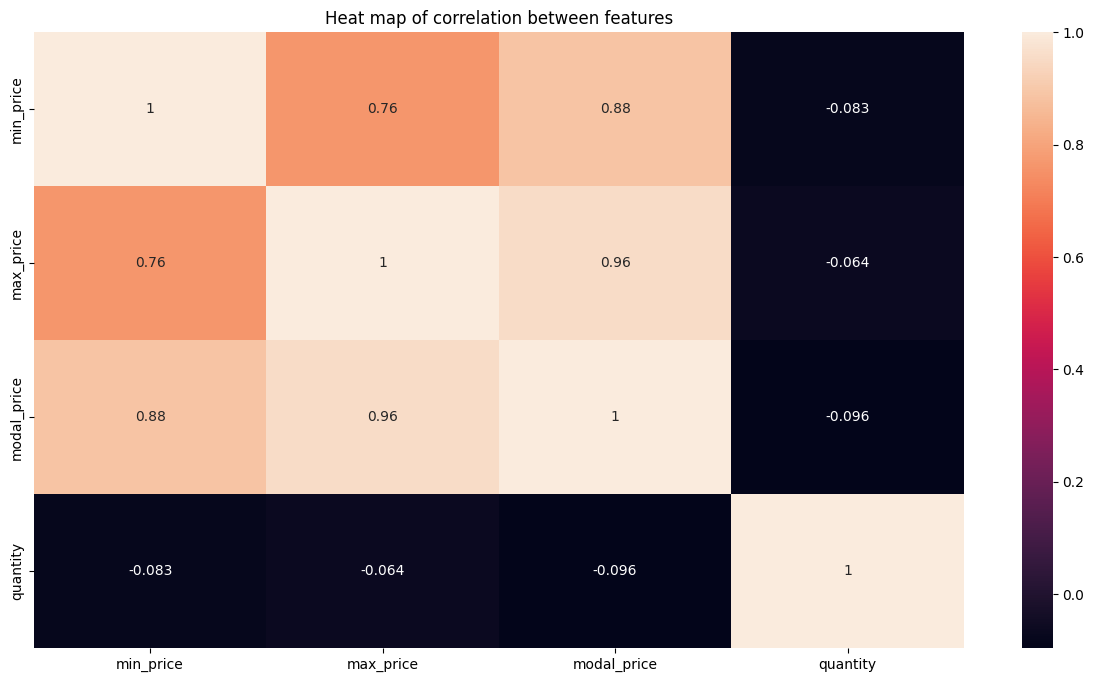

In [14]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [15]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [16]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [17]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

,modal_price
arrival_date,
2020-01-01,733
2020-01-02,986
2020-01-03,1047
2020-01-04,1033
2020-01-05,1033


# Preparing the dataset for training

### Creating Feature variable

In [18]:
# Function to create as many as features to represent the window size
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(0,winSize):
    df_temp["modal_price_t"+str(i+1)] = df_tomato_3['modal_price'].shift(i)
  return df_temp

In [19]:
# Generating new features
df_newFeatures = createWindow(5)
df_newFeatures.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5
arrival_date,,,,,
2020-01-01,733,NaN,NaN,NaN,NaN
2020-01-02,986,733.0,NaN,NaN,NaN
2020-01-03,1047,986.0,733.0,NaN,NaN
2020-01-04,1033,1047.0,986.0,733.0,NaN
2020-01-05,1033,1033.0,1047.0,986.0,733.0


In [20]:
# joining with base dataframe
df_tomato_4 = df_newFeatures.copy()
df_tomato_4.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5
arrival_date,,,,,
2020-01-01,733,NaN,NaN,NaN,NaN
2020-01-02,986,733.0,NaN,NaN,NaN
2020-01-03,1047,986.0,733.0,NaN,NaN
2020-01-04,1033,1047.0,986.0,733.0,NaN
2020-01-05,1033,1033.0,1047.0,986.0,733.0


In [21]:
# Replacing null values with 0, thus created window of 30 days as each input.
for val in df_tomato_4.columns:
  df_tomato_4[val].fillna(0, inplace=True)
df_tomato_4.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5
arrival_date,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0
2020-01-02,986,733.0,0.0,0.0,0.0
2020-01-03,1047,986.0,733.0,0.0,0.0
2020-01-04,1033,1047.0,986.0,733.0,0.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0


In [22]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

### Creating Target Variable

In [23]:
# Function to create as many as features to represent the window size
def createTargetWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_modal_price_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [24]:
# Generating target columns
df_newTargetCols = createTargetWindow(5)
df_newTargetCols.head()

,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,
2020-01-01,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1046.0,1153.0,933.0,1133.0,933.0


In [25]:
# joining with base dataframe
df_tomato_4 = df_tomato_4.join(df_newTargetCols)
df_tomato_4.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,986,733.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1047,986.0,733.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,1046.0,1153.0,933.0,1133.0,933.0


In [26]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,986,733.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1047,986.0,733.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,1046.0,1153.0,933.0,1133.0,933.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1000,1200.0,1130.0,1000.0,1000.0,1270.0,1200.0,1000.0,930.0,870.0
2023-03-10,1270,1000.0,1200.0,1130.0,1000.0,1200.0,1000.0,930.0,870.0,930.0
2023-03-11,1200,1270.0,1000.0,1200.0,1130.0,1000.0,930.0,870.0,930.0,730.0


### Scaling

In [27]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2020-01-01,0.091897,0.000000,0.000000,0.000000,0.000000,0.135517,0.146034,0.143621,0.143621,0.145862
2020-01-02,0.135517,0.122167,0.000000,0.000000,0.000000,0.146034,0.143621,0.143621,0.145862,0.164310
2020-01-03,0.146034,0.164333,0.122167,0.000000,0.000000,0.143621,0.143621,0.145862,0.164310,0.126379
2020-01-04,0.143621,0.174500,0.164333,0.122167,0.000000,0.143621,0.145862,0.164310,0.126379,0.160862
2020-01-05,0.143621,0.172167,0.174500,0.164333,0.122167,0.145862,0.164310,0.126379,0.160862,0.126379


### Train Test Split

In [28]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [29]:
# Creating Training dataset
train_X = pd.DataFrame(index=train_data.index)
train_y = pd.DataFrame(index=train_data.index)
for i in train_data.columns:
  if i.startswith('target'):
    train_y[i] = train_data[i]
  else:
    train_X[i] = train_data[i]

In [30]:
# Creating Testing dataset
test_X = pd.DataFrame(index=test_data.index)
test_y = pd.DataFrame(index=test_data.index)
for i in test_data.columns:
  if i.startswith('target'):
    test_y[i] = test_data[i]
  else:
    test_X[i] = test_data[i]

In [31]:
# Splitting target and feature variables
#train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

#test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [32]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [33]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((train_X.shape[0], 5, 1))
vec_train_y = vec_train_y.reshape((train_y.shape[0], 5, 1))

vec_test_X = vec_test_X.reshape((test_X.shape[0], 5, 1))
vec_test_y  = vec_test_y.reshape((test_y.shape[0], 5, 1))

In [34]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 5, 1) (926, 5, 1) (232, 5, 1) (232, 5, 1)


In [35]:
vec_train_X[10,:,:]

array([[0.16431034],
       [0.1555    ],
       [0.18883333],
       [0.1555    ],
       [0.19216667]])

# Model 1 - Encoder - Decoder model using LSTM

## Model building

In [36]:
# Build the Encoder - Decoder using LSTM model
# define model
model_encDec_1 = Sequential()
model_encDec_1.add(LSTM(128, activation='relu', 
                        input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]), 
                        return_sequences=True))
model_encDec_1.add(LSTM(64, activation='relu', return_sequences=False))
model_encDec_1.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_1.add(LSTM(64, activation='relu', return_sequences=True))
model_encDec_1.add(LSTM(128, activation='relu', return_sequences=True))
model_encDec_1.add(TimeDistributed(Dense(vec_train_X.shape[2])))
model_encDec_1.compile(optimizer='adam', loss='mae')
model_encDec_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 5, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 5, 1)             129       
 ibuted)                                                

In [37]:
# fit network
history = model_encDec_1.fit(vec_train_X, vec_train_y, epochs=50, batch_size=100, 
                             validation_data=(vec_test_X, vec_test_y), verbose=2,
                             shuffle=False)

Epoch 1/50
10/10 - 9s - loss: 0.1533 - val_loss: 0.0977 - 9s/epoch - 875ms/step
Epoch 2/50
10/10 - 1s - loss: 0.1169 - val_loss: 0.0679 - 549ms/epoch - 55ms/step
Epoch 3/50
10/10 - 1s - loss: 0.1121 - val_loss: 0.0663 - 545ms/epoch - 54ms/step
Epoch 4/50
10/10 - 1s - loss: 0.1097 - val_loss: 0.0636 - 592ms/epoch - 59ms/step
Epoch 5/50
10/10 - 1s - loss: 0.1048 - val_loss: 0.0613 - 938ms/epoch - 94ms/step
Epoch 6/50
10/10 - 1s - loss: 0.0944 - val_loss: 0.0589 - 1s/epoch - 118ms/step
Epoch 7/50
10/10 - 1s - loss: 0.0846 - val_loss: 0.0572 - 1s/epoch - 117ms/step
Epoch 8/50
10/10 - 1s - loss: 0.0793 - val_loss: 0.0522 - 1s/epoch - 118ms/step
Epoch 9/50
10/10 - 1s - loss: 0.0678 - val_loss: 0.0528 - 742ms/epoch - 74ms/step
Epoch 10/50
10/10 - 1s - loss: 0.0598 - val_loss: 0.0428 - 560ms/epoch - 56ms/step
Epoch 11/50
10/10 - 1s - loss: 0.0537 - val_loss: 0.0442 - 547ms/epoch - 55ms/step
Epoch 12/50
10/10 - 1s - loss: 0.0515 - val_loss: 0.0410 - 567ms/epoch - 57ms/step
Epoch 13/50
10/10 - 1

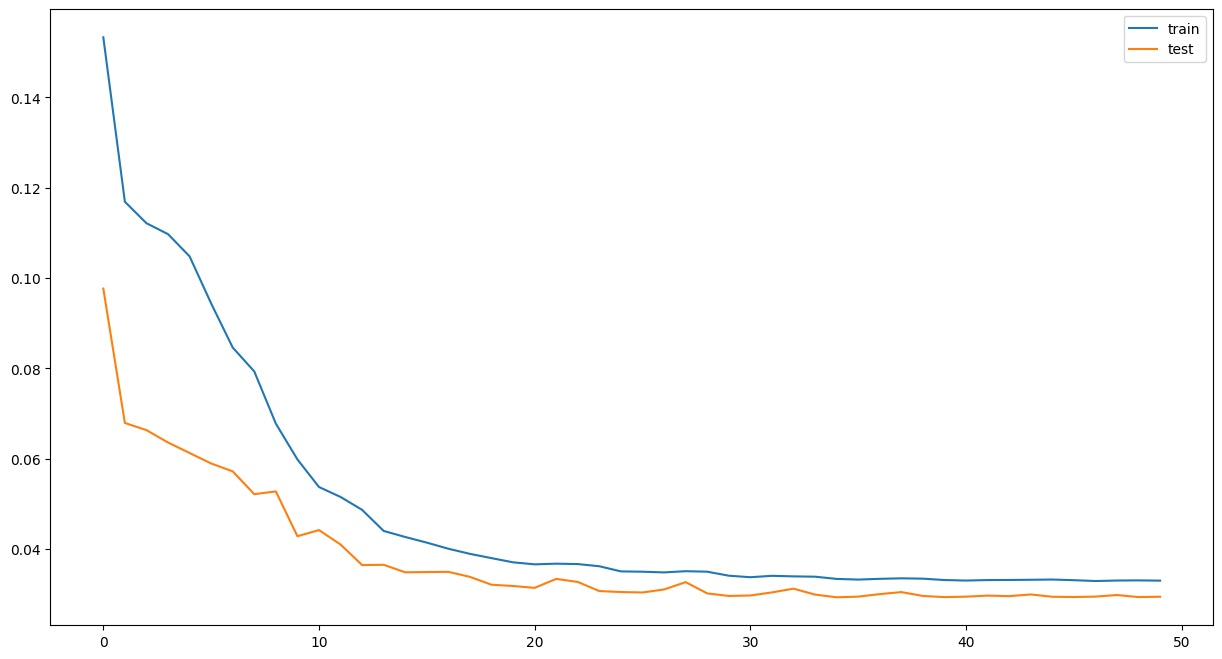

In [38]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [39]:
# make a prediction
pred_y = model_encDec_1.predict(vec_test_X)

8/8 [==============================] - 1s 11ms/step


In [40]:
pred_y[:5]

array([[[0.08456513],
        [0.08492669],
        [0.08306755],
        [0.08214363],
        [0.08249199]],

       [[0.08662553],
        [0.08724258],
        [0.08520909],
        [0.08415944],
        [0.08439979]],

       [[0.08362823],
        [0.0838774 ],
        [0.08209981],
        [0.08123244],
        [0.08162929]],

       [[0.08669976],
        [0.08732699],
        [0.08528736],
        [0.08423228],
        [0.08446784]],

       [[0.08860673],
        [0.08945967],
        [0.08726926],
        [0.08609236],
        [0.08622146]]], dtype=float32)

In [41]:
pred_y.shape

(232, 5, 1)

## Resacling Prediction

In [42]:
test_data

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.091379,0.081034,0.091379,0.091379,0.046552
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.081034,0.091379,0.091379,0.046552,0.056897
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.091379,0.091379,0.046552,0.056897,0.068966
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.091379,0.046552,0.056897,0.068966,0.081034
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.046552,0.056897,0.068966,0.081034,0.081034
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.184483,0.172414,0.137931,0.125862,0.115517
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.172414,0.137931,0.125862,0.115517,0.125862
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.137931,0.125862,0.115517,0.125862,0.091379


In [43]:
data_pred = test_data.copy()

In [44]:
for i in data_pred.columns:
  if i.startswith('target'):
    data_pred.drop(columns=i,inplace=True)

In [45]:
for i in range(0,5):
  data_pred['prediction_t'+str(i+1)] = pred_y[:,i]

In [46]:
data_pred

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.084565,0.084927,0.083068,0.082144,0.082492
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.086626,0.087243,0.085209,0.084159,0.084400
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.083628,0.083877,0.082100,0.081232,0.081629
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.086700,0.087327,0.085287,0.084232,0.084468
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.088607,0.089460,0.087269,0.086092,0.086221
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.148960,0.157695,0.155213,0.151687,0.148840
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.165361,0.175897,0.173047,0.169550,0.166801
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.168769,0.179614,0.176708,0.173189,0.170486


In [47]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [48]:
# Display Predicted values
inv_pred_y[:2,]

array([[690.47777057, 692.57482886, 681.79179728, 676.43308043,
        678.45356464],
       [702.42808163, 706.00696951, 694.21270192, 688.1247595 ,
        689.51877952]])

## Rescaling Actuals

In [49]:
data_actual= test_data.copy()

In [50]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [51]:
# Display Actual target values
inv_test_y[:2,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.]])

## Comapring Actuals vs Predicted

In [52]:
pred_df = pd.DataFrame(index=test_data.index)

In [53]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]


In [54]:
pred_df

,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,730.0,690.477771,670.0,692.574829,730.0,681.791797,730.0,676.433080,470.0,678.453565
2022-07-24,670.0,702.428082,730.0,706.006970,730.0,694.212702,470.0,688.124759,530.0,689.518780
2022-07-25,730.0,685.043733,730.0,686.488917,470.0,676.178899,530.0,671.148129,600.0,673.449889
2022-07-26,730.0,702.858616,470.0,706.496534,530.0,694.666702,600.0,688.547213,670.0,689.913447
2022-07-27,470.0,713.919035,530.0,718.866058,600.0,706.161717,670.0,699.335690,670.0,700.084491
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1270.0,1063.965374,1200.0,1114.633048,1000.0,1100.237811,930.0,1079.785615,870.0,1063.274652
2023-03-10,1200.0,1159.094590,1000.0,1220.203131,930.0,1203.673846,870.0,1183.390528,930.0,1167.448252
2023-03-11,1000.0,1178.859693,930.0,1241.761589,870.0,1224.907339,930.0,1204.498529,730.0,1188.819683


In [55]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [56]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i]).numpy()
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    12.017352
MAPE_2    15.901534
MAPE_3    17.834301
MAPE_4    18.810642
MAPE_5    19.478295
dtype: float64


In [57]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'Seq2Seq_LSTM'}, inplace= True)
model_comparision

,Seq2Seq_LSTM
MAPE_1,12.017352
MAPE_2,15.901534
MAPE_3,17.834301
MAPE_4,18.810642
MAPE_5,19.478295


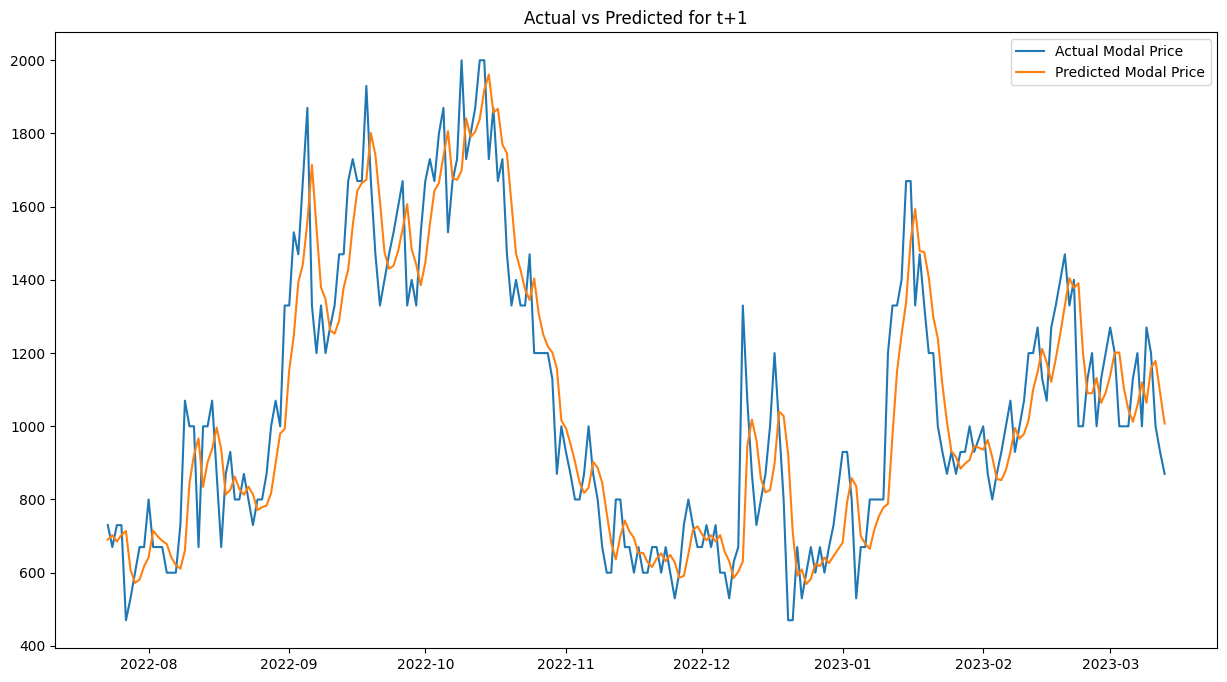

In [58]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 2 - Encoder - Decoder model using Bi LSTM

## Model building

In [59]:
# Build the Encoder - Decoder using Bi-LSTM model
model_encDec_2 = Sequential()
model_encDec_2.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_2.add(LSTM(32, activation='relu', return_sequences=False))
model_encDec_2.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_2.add(LSTM(32, activation='relu', return_sequences=True))
model_encDec_2.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_2.add(TimeDistributed(Dense(vec_train_X.shape[2])))
#model_encDec_2.build(input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]))
model_encDec_2.compile(optimizer='adam', loss='mae')
model_encDec_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           33792     
 l)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 32)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 5, 32)             8320      
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 128)           49664     
 nal)                                                            
                                                      

In [60]:
# fit network
history_2 = model_encDec_2.fit(vec_train_X, vec_train_y, epochs=50, batch_size=100, 
                             validation_data=(vec_test_X, vec_test_y), verbose=2,
                             shuffle=False)

Epoch 1/50
10/10 - 12s - loss: 0.1530 - val_loss: 0.0972 - 12s/epoch - 1s/step
Epoch 2/50
10/10 - 0s - loss: 0.1135 - val_loss: 0.0572 - 444ms/epoch - 44ms/step
Epoch 3/50
10/10 - 0s - loss: 0.1062 - val_loss: 0.0524 - 452ms/epoch - 45ms/step
Epoch 4/50
10/10 - 0s - loss: 0.1046 - val_loss: 0.0509 - 434ms/epoch - 43ms/step
Epoch 5/50
10/10 - 0s - loss: 0.1002 - val_loss: 0.0488 - 427ms/epoch - 43ms/step
Epoch 6/50
10/10 - 0s - loss: 0.0908 - val_loss: 0.0438 - 445ms/epoch - 45ms/step
Epoch 7/50
10/10 - 0s - loss: 0.0717 - val_loss: 0.0379 - 437ms/epoch - 44ms/step
Epoch 8/50
10/10 - 0s - loss: 0.0635 - val_loss: 0.0447 - 457ms/epoch - 46ms/step
Epoch 9/50
10/10 - 0s - loss: 0.0626 - val_loss: 0.0341 - 449ms/epoch - 45ms/step
Epoch 10/50
10/10 - 0s - loss: 0.0549 - val_loss: 0.0350 - 457ms/epoch - 46ms/step
Epoch 11/50
10/10 - 0s - loss: 0.0570 - val_loss: 0.0311 - 473ms/epoch - 47ms/step
Epoch 12/50
10/10 - 1s - loss: 0.0486 - val_loss: 0.0307 - 823ms/epoch - 82ms/step
Epoch 13/50
10/1

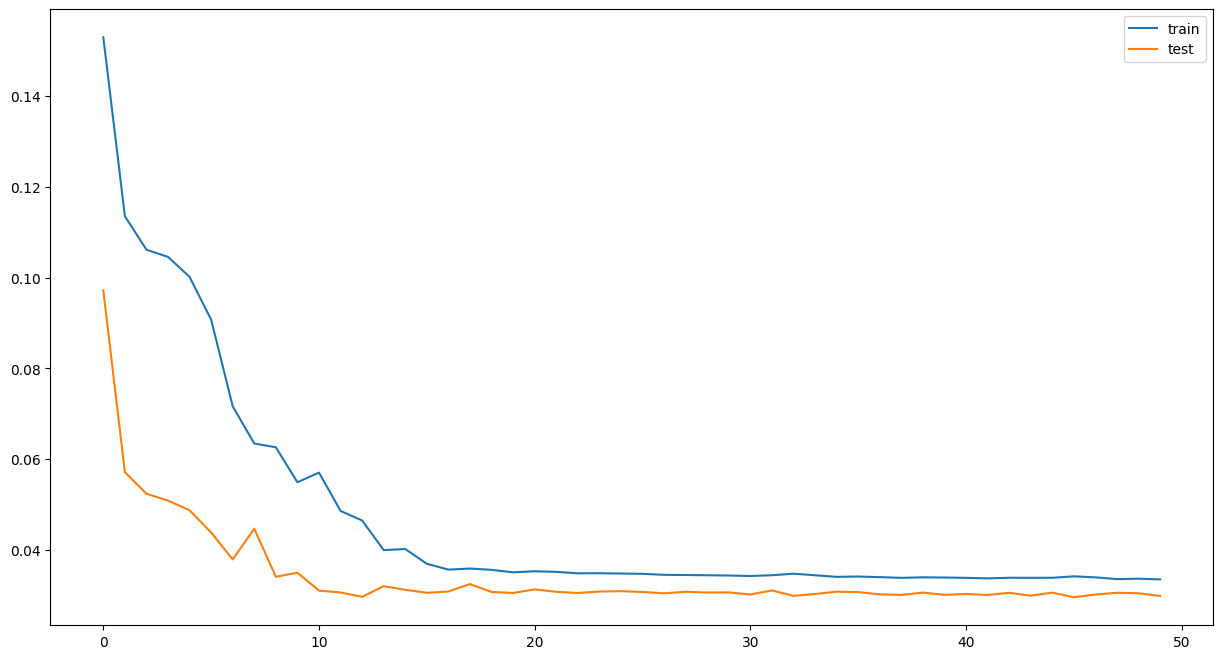

In [61]:
# plot history
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [62]:
# make a prediction
pred2_y = model_encDec_2.predict(vec_test_X)

8/8 [==============================] - 1s 7ms/step


In [63]:
pred2_y[:5]

array([[[0.08793463],
        [0.08911432],
        [0.08932315],
        [0.08850167],
        [0.08671816]],

       [[0.08779816],
        [0.08897455],
        [0.08918161],
        [0.08836047],
        [0.086579  ]],

       [[0.08473197],
        [0.08582924],
        [0.08599817],
        [0.08519387],
        [0.08348328]],

       [[0.08635452],
        [0.08749524],
        [0.08768568],
        [0.08687329],
        [0.08512461]],

       [[0.0882965 ],
        [0.08948717],
        [0.08970153],
        [0.08887821],
        [0.08708397]]], dtype=float32)

In [64]:
pred2_y.shape

(232, 5, 1)

## Resacling Prediction

In [65]:
data_pred2 = test_data.copy()

In [66]:
for i in data_pred2.columns:
  if i.startswith('target'):
    data_pred2.drop(columns=i,inplace=True)

In [67]:
for i in range(0,5):
  data_pred2['prediction_t'+str(i+1)] = pred2_y[:,i]

In [68]:
data_pred2

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.087935,0.089114,0.089323,0.088502,0.086718
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.087798,0.088975,0.089182,0.088360,0.086579
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.084732,0.085829,0.085998,0.085194,0.083483
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.086355,0.087495,0.087686,0.086873,0.085125
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.088297,0.089487,0.089702,0.088878,0.087084
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.154585,0.157070,0.157787,0.156403,0.152847
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.167995,0.170663,0.171410,0.169859,0.165922
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.174013,0.176751,0.177500,0.175868,0.171755


In [69]:
inv_pred2_y = scaler.inverse_transform(data_pred2)
inv_pred2_y = inv_pred2_y[:,-5:]

In [70]:
# Display Predicted values
inv_pred2_y[:2,]

array([[710.02084315, 716.8630749 , 718.07425916, 713.30968291,
        702.96531022],
       [709.22934711, 716.05239213, 717.25333482, 712.49074638,
        702.15821415]])

## Comapring Actuals vs Predicted

In [71]:
pred2_df = pd.DataFrame(index=test_data.index)

In [72]:
for i in range(0,5):
  pred2_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred2_df['prediction_t'+str(i+1)] = inv_pred2_y[:,i]


In [73]:
pred2_df

,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,730.0,710.020843,670.0,716.863075,730.0,718.074259,730.0,713.309683,470.0,702.965310
2022-07-24,670.0,709.229347,730.0,716.052392,730.0,717.253335,470.0,712.490746,530.0,702.158214
2022-07-25,730.0,691.445404,730.0,697.809610,470.0,698.789386,530.0,694.124460,600.0,684.203017
2022-07-26,730.0,700.856239,470.0,707.472378,530.0,708.576955,600.0,703.865099,670.0,693.722749
2022-07-27,470.0,712.119716,530.0,719.025558,600.0,720.268850,670.0,715.493643,670.0,705.087000
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1270.0,1096.594837,1200.0,1111.005458,1000.0,1115.164399,930.0,1107.136565,870.0,1086.514196
2023-03-10,1200.0,1174.369910,1000.0,1189.845654,930.0,1194.177708,870.0,1185.184488,930.0,1162.347606
2023-03-11,1000.0,1209.276459,930.0,1225.153568,870.0,1229.501006,930.0,1220.032093,730.0,1196.181080


In [74]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [75]:
# Calculate the error
error2 = pd.Series()
for i in range(0,5):
  error2['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i]).numpy()
print("Results of sklearn.metrics:")
print(error2)

Results of sklearn.metrics:
MAPE_1    12.917198
MAPE_2    15.986298
MAPE_3    18.008406
MAPE_4    19.102948
MAPE_5    19.769885
dtype: float64


In [76]:
model_comparision['Seq2Seq_BiDir_LSTM_2'] = error2
model_comparision

,Seq2Seq_LSTM,Seq2Seq_BiDir_LSTM_2
MAPE_1,12.017352,12.917198
MAPE_2,15.901534,15.986298
MAPE_3,17.834301,18.008406
MAPE_4,18.810642,19.102948
MAPE_5,19.478295,19.769885


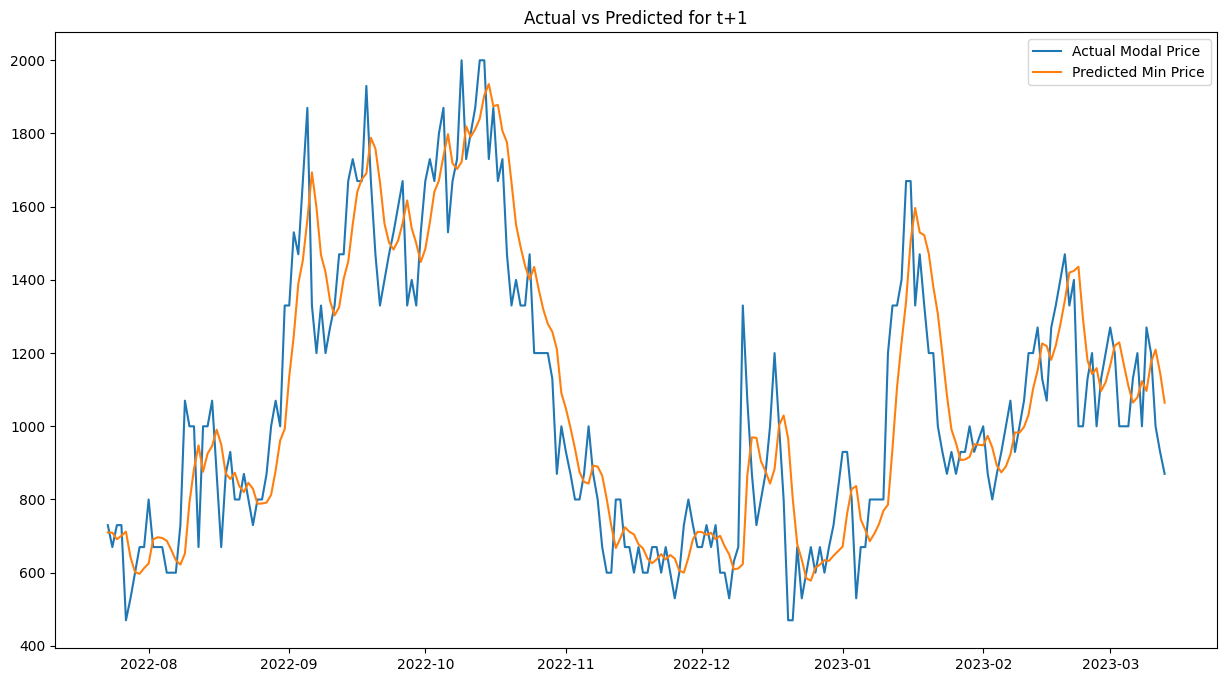

In [77]:
plt.plot(pred2_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred2_df['prediction_t1'],  label='Predicted Min Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 3 - Encoder - Decoder model using Bi LSTM  - Hyperparameter Tuning

## Model building

In [78]:
# Build the Encoder - Decoder using Bi-LSTM model
model_encDec_3 = Sequential()
model_encDec_3.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_3.add(Dropout(0.2))
model_encDec_3.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
model_encDec_3.add(Dropout(0.2))
model_encDec_3.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_3.add(Dropout(0.2))
model_encDec_3.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_encDec_3.add(Dropout(0.2))
model_encDec_3.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_3.add(Dropout(0.2))
model_encDec_3.add(TimeDistributed(Dense(vec_train_X.shape[2],activation='relu')))
#model_encDec_2.build(input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]))
model_encDec_3.compile(optimizer='adam', loss='mae')
model_encDec_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 5, 128)           33792     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 64)            0         
 or)                                                             
                                                      

In [79]:
# fit network
history_3 = model_encDec_3.fit(vec_train_X, vec_train_y, epochs=250, batch_size=250, 
                             validation_data=(vec_test_X, vec_test_y), verbose=1,
                             shuffle=False)

Epoch 1/250
4/4 [==============================] - 16s 601ms/step - loss: 0.1643 - val_loss: 0.1269
Epoch 2/250
4/4 [==============================] - 0s 117ms/step - loss: 0.1413 - val_loss: 0.0979
Epoch 3/250
4/4 [==============================] - 0s 116ms/step - loss: 0.1179 - val_loss: 0.0652
Epoch 4/250
4/4 [==============================] - 0s 125ms/step - loss: 0.1063 - val_loss: 0.0514
Epoch 5/250
4/4 [==============================] - 0s 117ms/step - loss: 0.1039 - val_loss: 0.0580
Epoch 6/250
4/4 [==============================] - 0s 122ms/step - loss: 0.1036 - val_loss: 0.0557
Epoch 7/250
4/4 [==============================] - 1s 209ms/step - loss: 0.0978 - val_loss: 0.0478
Epoch 8/250
4/4 [==============================] - 1s 207ms/step - loss: 0.0860 - val_loss: 0.0416
Epoch 9/250
4/4 [==============================] - 1s 219ms/step - loss: 0.0686 - val_loss: 0.0357
Epoch 10/250
4/4 [==============================] - 1s 224ms/step - loss: 0.0564 - val_loss: 0.0328
Epoch 11

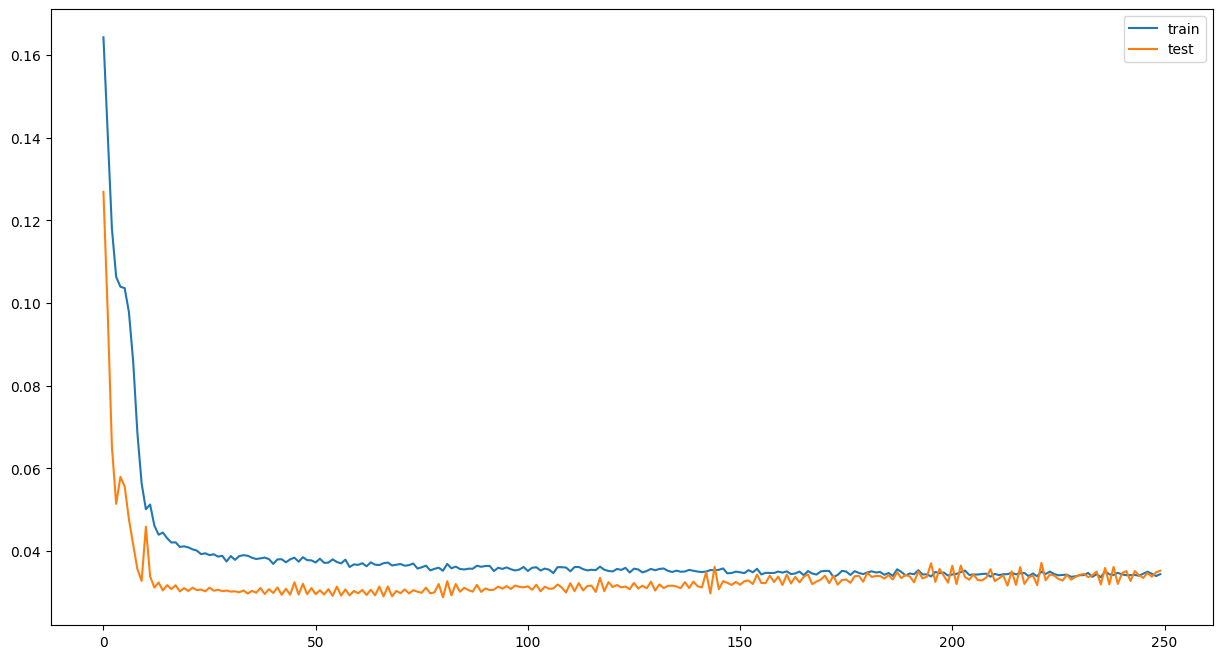

In [80]:
# plot history
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [81]:
# make a prediction
pred3_y = model_encDec_3.predict(vec_test_X)

8/8 [==============================] - 1s 10ms/step


In [82]:
pred3_y[:5]

array([[[0.06878527],
        [0.06879579],
        [0.06914113],
        [0.06970005],
        [0.07028855]],

       [[0.0709454 ],
        [0.07095001],
        [0.07130536],
        [0.0718888 ],
        [0.0725051 ]],

       [[0.06796445],
        [0.06794013],
        [0.06824152],
        [0.06875945],
        [0.0693154 ]],

       [[0.07060292],
        [0.07058893],
        [0.07092344],
        [0.07149051],
        [0.07209609]],

       [[0.07195897],
        [0.07196376],
        [0.0723291 ],
        [0.07293163],
        [0.07356968]]], dtype=float32)

In [83]:
pred3_y.shape

(232, 5, 1)

## Resacling Prediction

In [84]:
data_pred3 = test_data.copy()

In [85]:
for i in data_pred3.columns:
  if i.startswith('target'):
    data_pred3.drop(columns=i,inplace=True)

In [86]:
for i in range(0,5):
  data_pred3['prediction_t'+str(i+1)] = pred3_y[:,i]

In [87]:
data_pred3

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.068785,0.068796,0.069141,0.069700,0.070289
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.070945,0.070950,0.071305,0.071889,0.072505
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.067964,0.067940,0.068242,0.068759,0.069315
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.070603,0.070589,0.070923,0.071491,0.072096
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.071959,0.071964,0.072329,0.072932,0.073570
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.118770,0.119587,0.121029,0.122733,0.124183
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.134884,0.135960,0.137755,0.139805,0.141460
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.136383,0.137522,0.139394,0.141513,0.143200


In [88]:
inv_pred3_y = scaler.inverse_transform(data_pred3)
inv_pred3_y = inv_pred3_y[:,-5:]

In [89]:
# Display Predicted values
inv_pred3_y[:2,]

array([[598.95458072, 599.01555479, 601.01853758, 604.26031798,
        607.67356902],
       [611.48334593, 611.51005179, 613.57107013, 616.95506573,
        620.52958906]])

## Comapring Actuals vs Predicted

In [90]:
pred3_df = pd.DataFrame(index=test_data.index)

In [91]:
for i in range(0,5):
  pred3_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred3_df['prediction_t'+str(i+1)] = inv_pred3_y[:,i]


In [92]:
pred3_df

,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,730.0,598.954581,670.0,599.015555,730.0,601.018538,730.0,604.260318,470.0,607.673569
2022-07-24,670.0,611.483346,730.0,611.510052,730.0,613.571070,470.0,616.955066,530.0,620.529589
2022-07-25,730.0,594.193807,730.0,594.052759,470.0,595.800826,530.0,598.804803,600.0,602.029341
2022-07-26,730.0,609.496957,470.0,609.415802,530.0,611.355953,600.0,614.644966,670.0,618.157348
2022-07-27,470.0,617.362049,530.0,617.389792,600.0,619.508760,670.0,623.003468,670.0,626.704131
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1270.0,888.864248,1200.0,893.604322,1000.0,901.967923,930.0,911.853154,870.0,920.261179
2023-03-10,1200.0,982.327890,1000.0,988.568678,930.0,998.977309,870.0,1010.870147,930.0,1020.468354
2023-03-11,1000.0,991.020605,930.0,997.629225,870.0,1008.487707,930.0,1020.775515,730.0,1030.557984


In [93]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [94]:
# Calculate the error
error3 = pd.Series()
for i in range(0,5):
  error3['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred3_y[:,i]).numpy()
print("Results of sklearn.metrics:")
print(error3)

Results of sklearn.metrics:
MAPE_1    17.024883
MAPE_2    18.025871
MAPE_3    18.556923
MAPE_4    18.758935
MAPE_5    19.259366
dtype: float64


In [95]:
model_comparision['Seq2Seq_BiDir_LSTM_3'] = error3
model_comparision

,Seq2Seq_LSTM,Seq2Seq_BiDir_LSTM_2,Seq2Seq_BiDir_LSTM_3
MAPE_1,12.017352,12.917198,17.024883
MAPE_2,15.901534,15.986298,18.025871
MAPE_3,17.834301,18.008406,18.556923
MAPE_4,18.810642,19.102948,18.758935
MAPE_5,19.478295,19.769885,19.259366


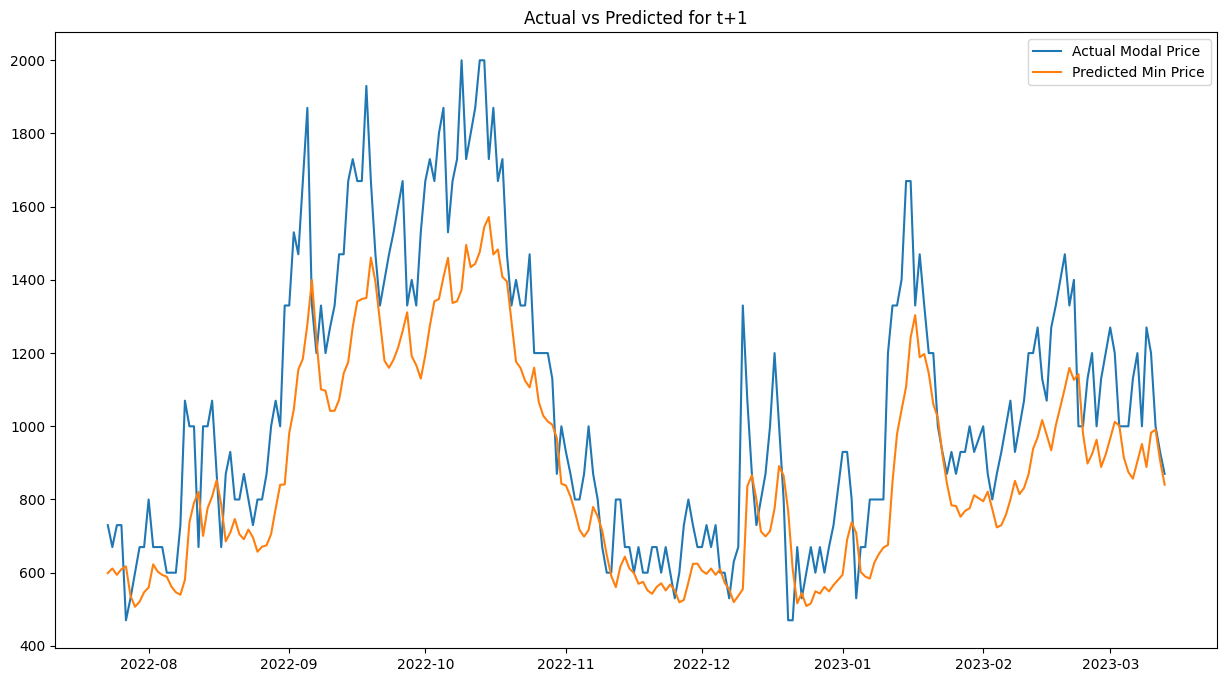

In [96]:
plt.plot(pred3_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred3_df['prediction_t1'],  label='Predicted Min Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 4 - Encoder - Decoder model using Bi LSTM  - Hyperparameter Tuning

## Model building

In [97]:
# Build the Encoder - Decoder using Bi-LSTM model
model_encDec_4 = Sequential()
model_encDec_4.add(Bidirectional(LSTM(8, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_4.add(Dropout(0.2))
#model_encDec_4.add(BatchNormalization())
model_encDec_4.add((LSTM(8, activation='relu', return_sequences=False)))
model_encDec_4.add(Dropout(0.2))
model_encDec_4.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_4.add(Dropout(0.2))
#model_encDec_4.add(BatchNormalization())
model_encDec_4.add((LSTM(8, activation='relu', return_sequences=True)))
model_encDec_4.add(Dropout(0.2))
#model_encDec_4.add(BatchNormalization())
model_encDec_4.add(Bidirectional(LSTM(8, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_4.add(Dropout(0.2))
model_encDec_4.add(TimeDistributed(Dense(vec_train_X.shape[2])))
#model_encDec_2.build(input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]))
model_encDec_4.compile(optimizer='Adam', loss='mae')
model_encDec_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 5, 16)            640       
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 5, 16)             0         
                                                                 
 lstm_13 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 5, 8)             0         
 or)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 8)             

In [98]:
# fit network
history_4 = model_encDec_4.fit(vec_train_X, vec_train_y, epochs=250, batch_size=100, 
                             validation_data=(vec_test_X, vec_test_y), verbose=1,
                             shuffle=False)

Epoch 1/250
10/10 [==============================] - 12s 140ms/step - loss: 0.1549 - val_loss: 0.1106
Epoch 2/250
10/10 [==============================] - 0s 26ms/step - loss: 0.1231 - val_loss: 0.0736
Epoch 3/250
10/10 [==============================] - 0s 27ms/step - loss: 0.1095 - val_loss: 0.0570
Epoch 4/250
10/10 [==============================] - 0s 26ms/step - loss: 0.1068 - val_loss: 0.0532
Epoch 5/250
10/10 [==============================] - 0s 29ms/step - loss: 0.1069 - val_loss: 0.0523
Epoch 6/250
10/10 [==============================] - 0s 26ms/step - loss: 0.1069 - val_loss: 0.0522
Epoch 7/250
10/10 [==============================] - 0s 25ms/step - loss: 0.1045 - val_loss: 0.0522
Epoch 8/250
10/10 [==============================] - 0s 27ms/step - loss: 0.1033 - val_loss: 0.0519
Epoch 9/250
10/10 [==============================] - 0s 29ms/step - loss: 0.1007 - val_loss: 0.0512
Epoch 10/250
10/10 [==============================] - 0s 27ms/step - loss: 0.0989 - val_loss: 0.05

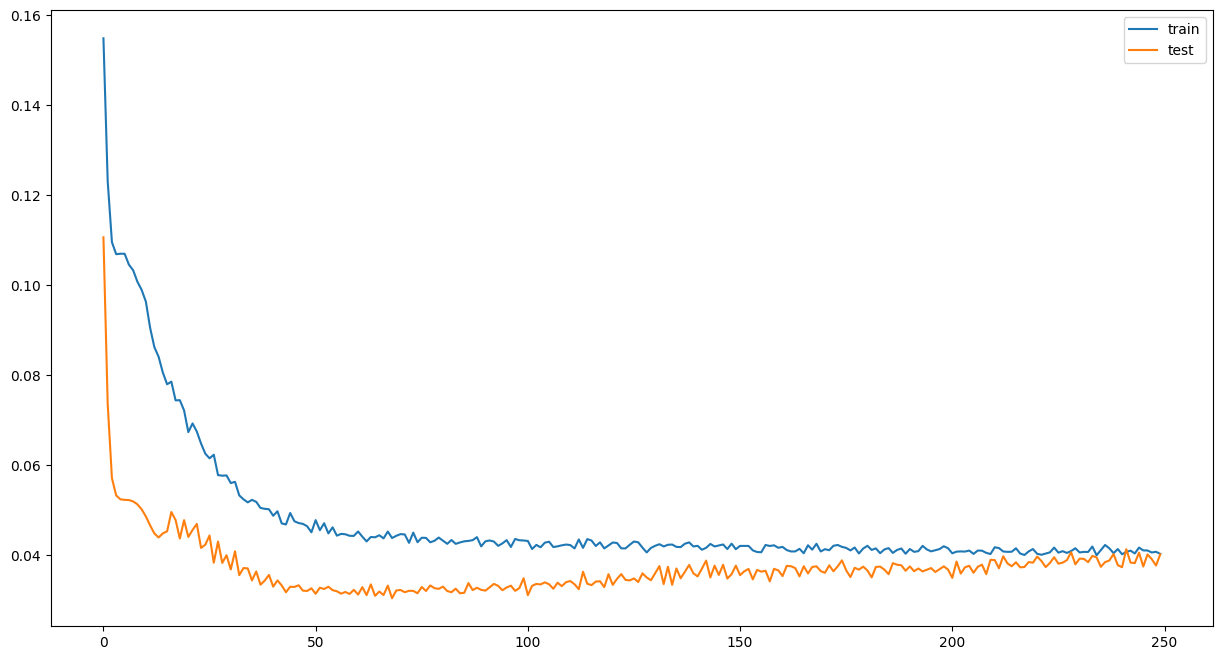

In [99]:
# plot history
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [100]:
# make a prediction
pred4_y = model_encDec_4.predict(vec_test_X)

8/8 [==============================] - 1s 6ms/step


In [101]:
pred4_y[:5]

array([[[0.06755269],
        [0.06718019],
        [0.06703691],
        [0.06721929],
        [0.06780289]],

       [[0.06737787],
        [0.06700601],
        [0.06686426],
        [0.06704801],
        [0.06763197]],

       [[0.0657313 ],
        [0.06540103],
        [0.06528076],
        [0.06545821],
        [0.06600221]],

       [[0.06685268],
        [0.06649284],
        [0.0663588 ],
        [0.06654327],
        [0.06711885]],

       [[0.06802114],
        [0.0676313 ],
        [0.06748243],
        [0.06767236],
        [0.06827775]]], dtype=float32)

In [102]:
pred4_y.shape

(232, 5, 1)

## Resacling Prediction

In [103]:
data_pred4 = test_data.copy()

In [104]:
for i in data_pred4.columns:
  if i.startswith('target'):
    data_pred4.drop(columns=i,inplace=True)

In [105]:
for i in range(0,5):
  data_pred4['prediction_t'+str(i+1)] = pred4_y[:,i]

In [106]:
data_pred4

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.067553,0.067180,0.067037,0.067219,0.067803
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.067378,0.067006,0.066864,0.067048,0.067632
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.065731,0.065401,0.065281,0.065458,0.066002
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.066853,0.066493,0.066359,0.066543,0.067119
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.068021,0.067631,0.067482,0.067672,0.068278
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.113625,0.112379,0.111694,0.111817,0.112898
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.124199,0.122861,0.122073,0.122120,0.123147
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.127614,0.126249,0.125442,0.125468,0.126472


In [107]:
inv_pred4_y = scaler.inverse_transform(data_pred4)
inv_pred4_y = inv_pred4_y[:,-5:]

In [108]:
# Display Predicted values
inv_pred4_y[:2,]

array([[591.80557728, 589.64508176, 588.8140887 , 589.87186551,
        593.25676858],
       [590.79161882, 588.63483965, 587.81270534, 588.87847662,
        592.26541072]])

## Comapring Actuals vs Predicted

In [109]:
pred4_df = pd.DataFrame(index=test_data.index)

In [110]:
for i in range(0,5):
  pred4_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred4_df['prediction_t'+str(i+1)] = inv_pred4_y[:,i]


In [111]:
pred4_df

,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,730.0,591.805577,670.0,589.645082,730.0,588.814089,730.0,589.871866,470.0,593.256769
2022-07-24,670.0,590.791619,730.0,588.634840,730.0,587.812705,470.0,588.878477,530.0,592.265411
2022-07-25,730.0,581.241551,730.0,579.325989,470.0,578.628395,530.0,579.657608,600.0,582.812789
2022-07-26,730.0,587.745552,470.0,585.658476,530.0,584.881067,600.0,585.950944,670.0,589.289349
2022-07-27,470.0,594.522618,530.0,592.261565,600.0,591.398075,670.0,592.499714,670.0,596.010929
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1270.0,859.025633,1200.0,851.796037,1000.0,847.827840,930.0,848.539996,870.0,854.810169
2023-03-10,1200.0,920.356464,1000.0,912.591973,930.0,908.026135,870.0,908.294490,930.0,914.254823
2023-03-11,1000.0,940.159336,930.0,932.243425,870.0,927.562293,930.0,927.713108,730.0,933.535850


In [112]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [113]:
# Calculate the error
error4 = pd.Series()
for i in range(0,5):
  error4['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred4_y[:,i]).numpy()
print("Results of sklearn.metrics:")
print(error4)

Results of sklearn.metrics:
MAPE_1    19.137378
MAPE_2    20.111108
MAPE_3    20.487070
MAPE_4    20.860204
MAPE_5    21.001387
dtype: float64


In [114]:
model_comparision['Seq2Seq_BiDir_LSTM_4'] = error4
model_comparision

,Seq2Seq_LSTM,Seq2Seq_BiDir_LSTM_2,Seq2Seq_BiDir_LSTM_3,Seq2Seq_BiDir_LSTM_4
MAPE_1,12.017352,12.917198,17.024883,19.137378
MAPE_2,15.901534,15.986298,18.025871,20.111108
MAPE_3,17.834301,18.008406,18.556923,20.487070
MAPE_4,18.810642,19.102948,18.758935,20.860204
MAPE_5,19.478295,19.769885,19.259366,21.001387


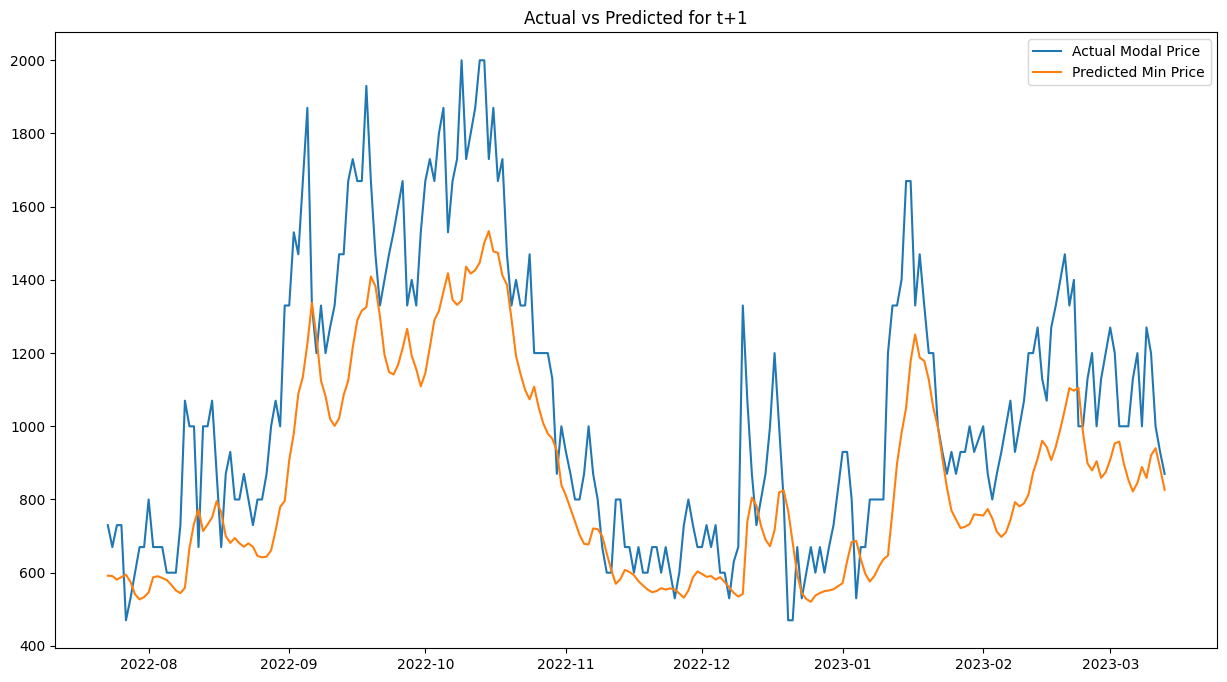

In [115]:
plt.plot(pred4_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t1'],  label='Predicted Min Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Comparing all models

In [116]:
model_comparision

,Seq2Seq_LSTM,Seq2Seq_BiDir_LSTM_2,Seq2Seq_BiDir_LSTM_3,Seq2Seq_BiDir_LSTM_4
MAPE_1,12.017352,12.917198,17.024883,19.137378
MAPE_2,15.901534,15.986298,18.025871,20.111108
MAPE_3,17.834301,18.008406,18.556923,20.487070
MAPE_4,18.810642,19.102948,18.758935,20.860204
MAPE_5,19.478295,19.769885,19.259366,21.001387


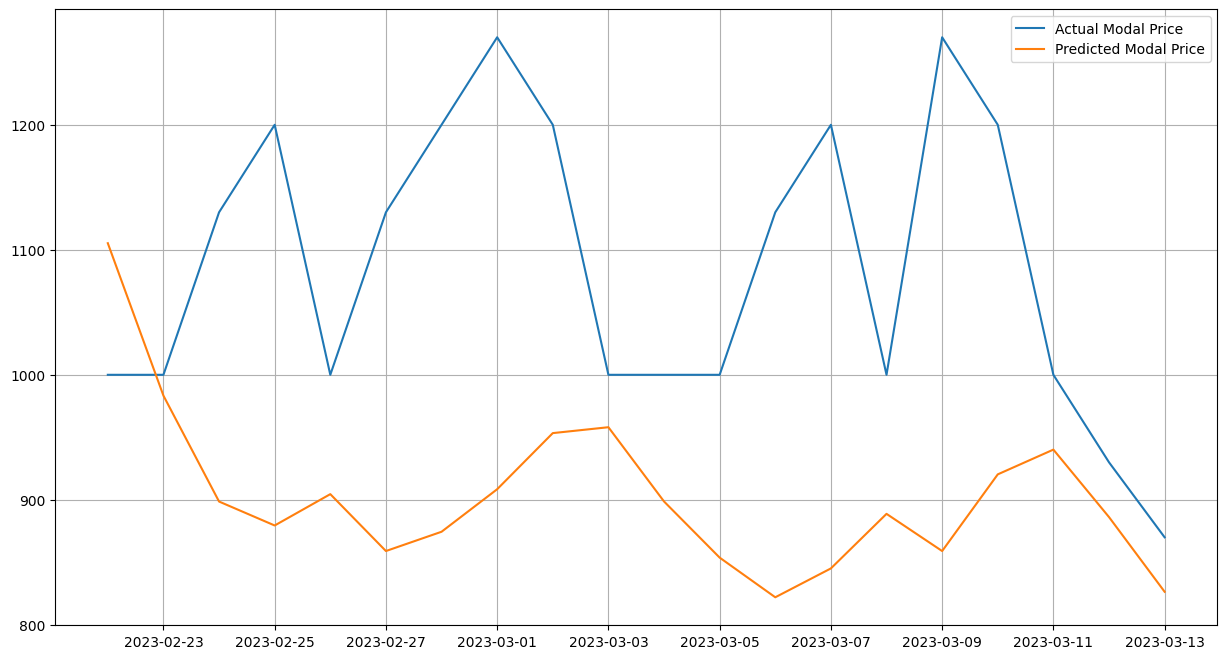

In [117]:
plt.plot(pred4_df['modal_price_actual_t1'][-20:], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t1'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()

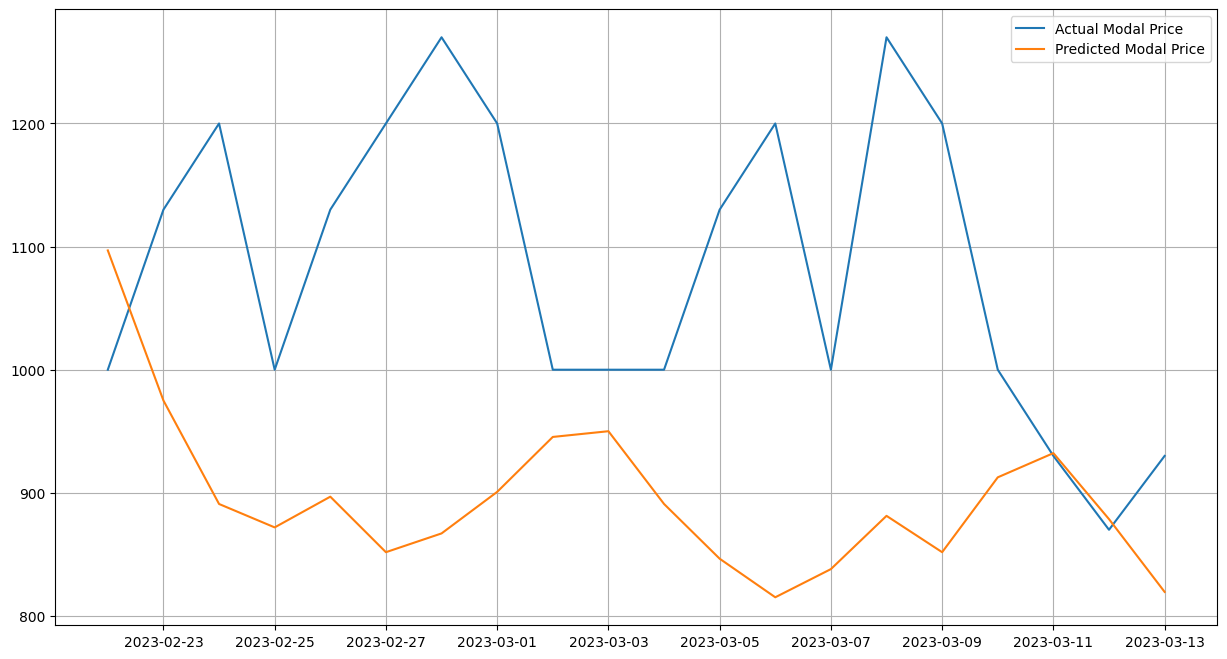

In [118]:
plt.plot(pred4_df['modal_price_actual_t2'][-20:], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t2'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()

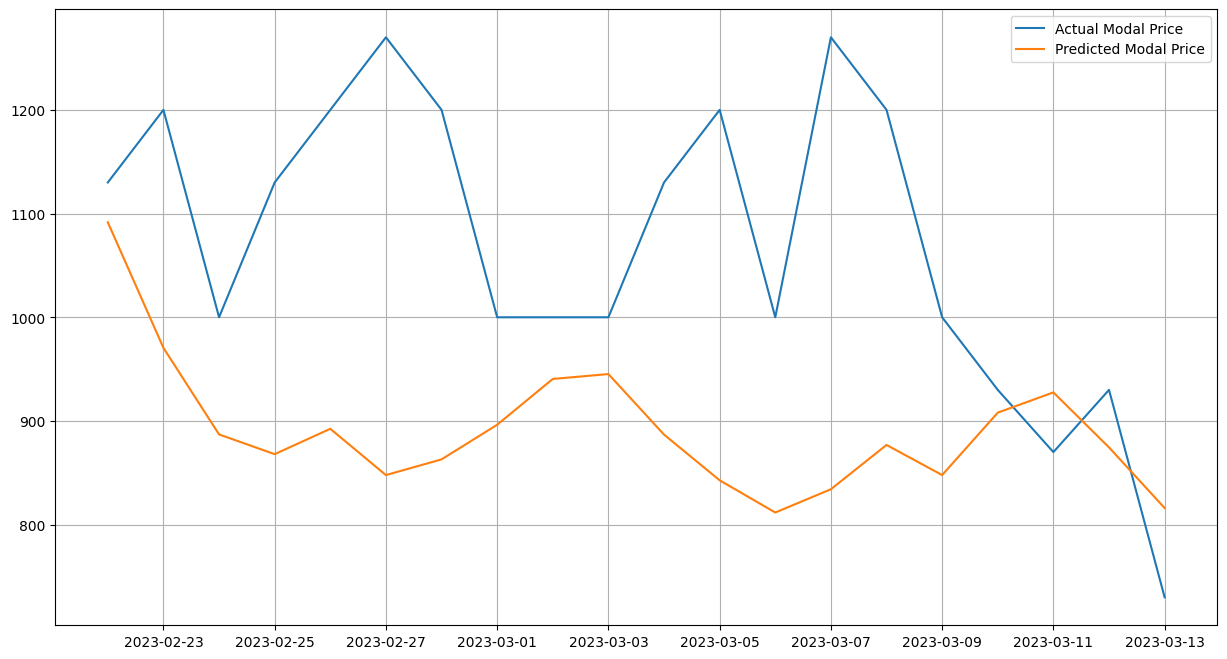

In [119]:
plt.plot(pred4_df['modal_price_actual_t3'][-20:], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t3'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()

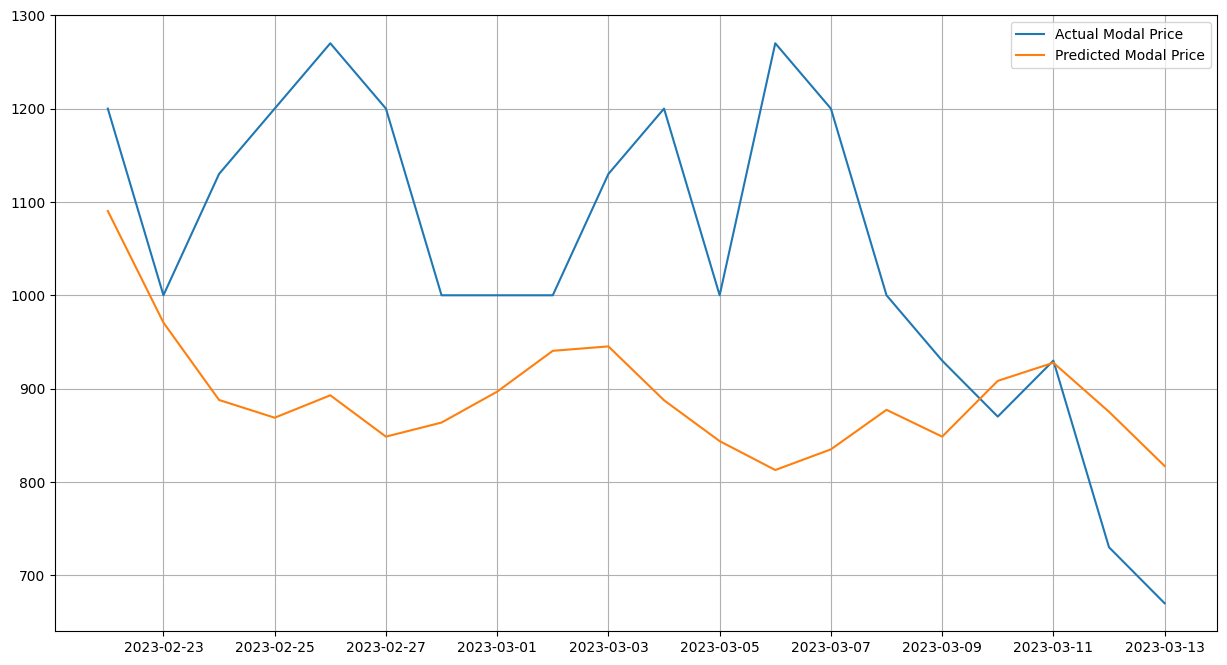

In [120]:
plt.plot(pred4_df['modal_price_actual_t4'][-20:], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t4'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()

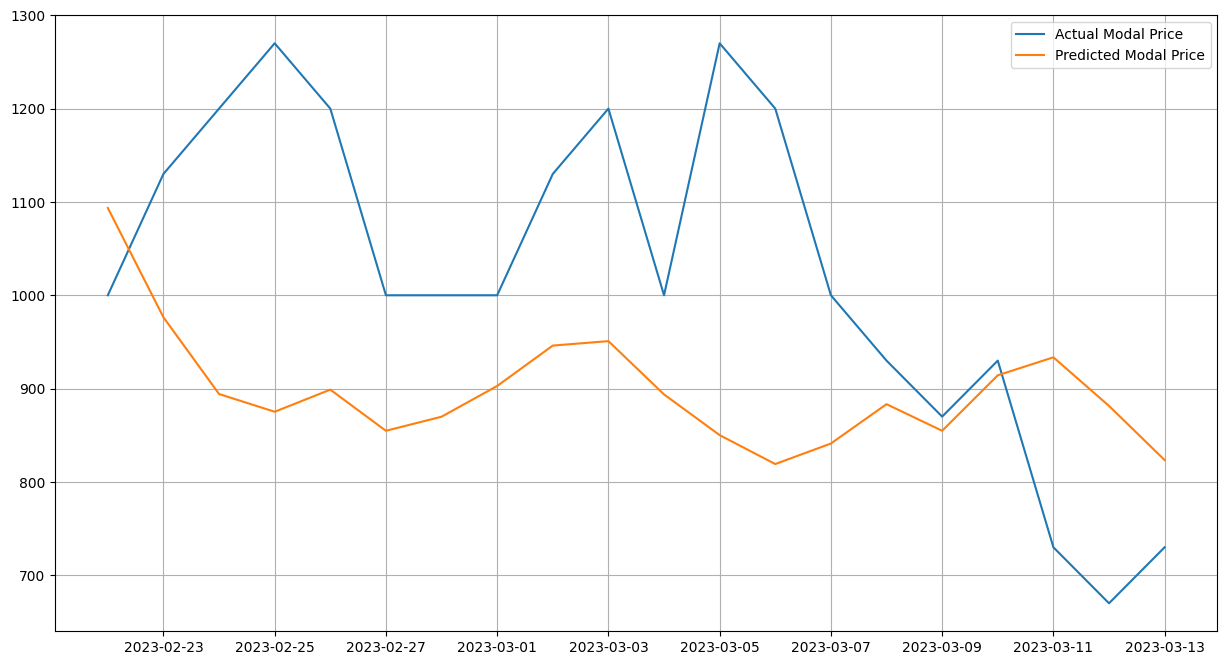

In [121]:
plt.plot(pred4_df['modal_price_actual_t5'][-20:], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t5'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()